# Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 CLI
############################################################################################# 100.0%
>>> Making ollama accessible in the PATH in /usr/local/bin
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
def start_ollama():
    t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
    t.start()

In [ ]:
def pull_model(local_llm):
    !ollama pull local_llm

In [ ]:
def start_model(local_llm):
    t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", local_llm]),daemon=True)
    t2.start()

In [ ]:
%%capture --no-stderr
%pip install -U scikit-learn==1.3 langchain-ai21 langchain_community tiktoken langchainhub langchain

In [ ]:
import os

os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
#os.environ["LANGCHAIN_PROJECT"]="hate-speech-project"

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from langchain_community.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

In [ ]:
# todo #all'incirca 7.000 testi di test

df = pd.read_csv("/content/drive/MyDrive/predictions_hate/HateSpeechDatasetBalanced.csv")

print(len(df))

#label_0 = df[df["Label"]==0] #no hate speech
#label_1 = df[df["Label"]==1] #hate speech
#print(f"Label con valore 0: {len(label_0)}")
#print(f"Label con valore 1: {len(label_1)}")

# Campiona l'1% del DataFrame
sampled_df = df.sample(frac=0.01, random_state=42)

x_test = sampled_df["Content"]
y_test = sampled_df["Label"]

print(len(x_test))
print(len(y_test))

label_0 = sampled_df[sampled_df["Label"]==0] #no hate speech
label_1 = sampled_df[sampled_df["Label"]==1] #hate speech
print(f"Label con valore 0: {len(label_0)}")
print(f"Label con valore 1: {len(label_1)}")

726119
7261
7261
Label con valore 0: 3584
Label con valore 1: 3677


In [ ]:
# Support functions

import json

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)


def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)


# Encoder

## Finetuning

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm

In [ ]:
# Campiona l'1% del DataFrame
training_df = df.sample(frac=0.015, random_state=41)

print(len(training_df))

training_df = training_df[~training_df.isin(sampled_df).all(axis=1)] #elimino elementi che possono essere presenti nel testing

print(len(training_df))

10892
10784


In [ ]:
x_train = training_df["Content"]
x_label = training_df["Label"]

print(len(x_train))
print(len(x_label))

label_0 = training_df[training_df["Label"]==0] #no hate speech
label_1 = training_df[training_df["Label"]==1] #hate speech
print(f"Label con valore 0: {len(label_0)}")
print(f"Label con valore 1: {len(label_1)}")

10784
10784
Label con valore 0: 5306
Label con valore 1: 5478


In [ ]:
# Lunghezza media dei testi

# Calcola la lunghezza di ciascun testo
lens = [len(text) for text in x_train]

# Somma le lunghezze e calcola la lunghezza media
avg_len = sum(lens) / len(x_train)

print(avg_len) #lunghezza media
print(max(lens)) #massima lunghezza
print(len([l for l in lens if l>1024])) #numero di testi con lunghezza superiore a 1024

195.89892433234422
4967
225


In [ ]:
#tokenizer di BERT e Roberta
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

#tokenizzazione dei dati
input_ids = []
attention_masks = []

for sentence in x_train:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True,
                        max_length = None, #Uso della massima lunghezza del modello, nel caso di BERT 512 tokens
                        padding = "max_length",
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# Convertire in tensori
input_ids_tensor = torch.cat(input_ids, dim=0)
attention_masks_tensor = torch.cat(attention_masks, dim=0)
labels_tensor = torch.tensor(list(x_label))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

dataset = CustomDataset(input_ids_tensor, attention_masks_tensor, labels_tensor)
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
"""
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
"""
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Training

In [ ]:
model.train()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

epochs = 4

for epoch in range(epochs):
    total_loss = 0

    for batch in tqdm(train_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss = loss.item()+total_loss
        #print(f"Loss: {loss.item()}")

    print(f"Loss epoch {epoch}: {total_loss/len(train_dataloader)}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 674/674 [15:16<00:00,  1.36s/it]


Loss epoch 0: 0.45229101881871236


100%|██████████| 674/674 [15:16<00:00,  1.36s/it]


Loss epoch 1: 0.29669615013375655


100%|██████████| 674/674 [15:16<00:00,  1.36s/it]


Loss epoch 2: 0.17695932155502656


100%|██████████| 674/674 [15:16<00:00,  1.36s/it]

Loss epoch 3: 0.10548902735167986


In [ ]:
model.save_pretrained('/content/drive/MyDrive/predictions_hate/fine_tuned_roberta')

## Testing functions

In [ ]:
# Testing del modello

def predict_bert_supp(sentences,model):
  if model == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/predictions_hate/fine_tuned_bert')
  elif model == "RoBERTa":
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/predictions_hate/fine_tuned_roberta')

  model.eval()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  input_ids = []
  attention_masks = []

  for sentence in sentences:
      encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True,
                        max_length = None, #Uso della massima lunghezza del modello, nel caso di BERT 512 tokens
                        padding = "max_length",
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])

  input_ids_tensor = torch.cat(input_ids, dim=0).to(device)
  attention_masks_tensor = torch.cat(attention_masks, dim=0).to(device)

  with torch.no_grad():
    outputs = model(input_ids=input_ids_tensor, attention_mask=attention_masks_tensor)

  # Estrai i logits (output non normalizzati del modello)
  logits = outputs.logits

  # Converti i logits in probabilità (se necessario)
  probs = torch.softmax(logits, dim=1)

  # Identifica la classe con la probabilità più alta
  predicted_class = torch.argmax(probs, dim=1)

  return predicted_class

In [ ]:
# prova BERT

def predict_bert(x_test,model):
  y_pred = []
  dim_group = 300
  for i in range(0, len(x_test), dim_group): #prendo gruppi da 100
    group = x_test[i:i + dim_group]
    y_bert = predict_bert_supp(group,model)
    y_pred.append(y_bert)

  y_final = list(torch.cat(y_pred, dim=0).cpu().numpy())
  return y_final

# LLM

In [ ]:
examples = [
    {"input": "We need to keep our culture pure.", "output": "yes"},
    {"input": "Fuck you.", "output": "yes"},
    {"input": "It’s important to respect other people's choices.", "output": "no"},
    {"input": "Some groups of people are bastards", "output": "yes"},
    {"input": "I think the weather is nice today.", "output": "no"},
    {"input": "Go back to where you came from, asshole.", "output": "yes"},
    {"input": "Have a great day!.", "output": "no"},
    {"input": "They're just different, and that's not a bad thing, but they shouldn't try to change us.", "output": "yes"},
]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

def create_prompt(shot):
    example_prompt  = ChatPromptTemplate.from_messages(
        [
            ("user", "{input}"),
            ("assistant", "{output}"),
        ]
    )

    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt ,
        examples=examples[:shot], #:2 two-shot, #4: four-shot #8 eight-shot
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """You are an helpful assistant who has to detect the presence of hate speech.
                Hate speech is speech that attacks a person or group based on attributes such as race, religion, ethnic origin, national origin, sex, disability, sexual orientation, or gender identity.
                You have to answer "yes" if it contains hate speech, or "no" if it doesn't contain hate speech.
                Give only the answer "yes" or "no", NO PREAMBLE, NO EXPLANATIONS."""),
             few_shot_prompt,
            ("user", "{input}"),
        ] if shot>0 else
        [
            ("system", """You are an helpful assistant who has to detect the presence of hate speech.
                Hate speech is speech that attacks a person or group based on attributes such as race, religion, ethnic origin, national origin, sex, disability, sexual orientation, or gender identity.
                You have to answer "yes" if it contains hate speech, or "no" if it doesn't contain hate speech.
                Give only the answer "yes" or "no", NO PREAMBLE, NO EXPLANATIONS."""),
            ("user", "{input}"),
        ]
    )
    return prompt

In [ ]:
#import functools
import sys
import io

def hate_speech_detection(llm, shot):
    prompt_final = create_prompt(shot)
    hate_speech_detection = prompt_final | llm
    return hate_speech_detection

In [ ]:
def predict(llm,x_test,shot):
    y_pred = []
    chain = hate_speech_detection(llm,shot)
    for x in tqdm(x_test):
        answer = chain.invoke({"input": x})
        #print(answer)
        if "no" in answer.lower(): y_pred.append(0) #no hate speech
        else: y_pred.append(1) #hate speech
    return y_pred

# Testing

In [ ]:
import time

models = ["RoBERTa"]
shots = [0,2,4,8]

for model in models:
    if model=="BERT" or model=="RoBERTa":
      y_pred = predict_bert(x_test,model)
      y_list = [int(x) for x in y_pred]
      write_file(f"/content/drive/MyDrive/predictions_hate/prediction_hate_speech_{model}.json", y_list)
    else:
      start_ollama()
      pull_model(model)
      start_model(model)
      time.sleep(500)
      llm = Ollama(model=model, temperature=0)
      for shot in shots:
          y_pred = predict(llm,x_test,shot)
          if model=="llama3.1":
              write_file(f"/content/drive/MyDrive/predictions_hate/prediction_hate_speech_llama31_{shot}_shot.json", y_pred)
          else:
              write_file(f"/content/drive/MyDrive/predictions_hate/prediction_hate_speech_{model}_{shot}_shot.json", y_pred)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Evaluation

In [ ]:
# Label 0: no hate speech
# Label 1: hate speech

#model = "llama31" #gemma2 #mistral #llama31
#shot = 0 #2 #4 #8
y_pred = load_json("/content/drive/MyDrive/predictions_hate/prediction_hate_speech_BERT.json") #reading predictions

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, labels=[0,1], output_dict=True)

TN, FP, FN, TP = conf_matrix.ravel()

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.8259192948629666
Confusion Matrix:
[[3177  407]
 [ 857 2820]]
Classification Report:
{'0': {'precision': 0.7875557759048091, 'recall': 0.8864397321428571, 'f1-score': 0.8340771856130216, 'support': 3584.0}, '1': {'precision': 0.8738766656337156, 'recall': 0.7669295621430514, 'f1-score': 0.816917728852839, 'support': 3677.0}, 'accuracy': 0.8259192948629666, 'macro avg': {'precision': 0.8307162207692623, 'recall': 0.8266846471429543, 'f1-score': 0.8254974572329303, 'support': 7261.0}, 'weighted avg': {'precision': 0.8312690263569767, 'recall': 0.8259192948629666, 'f1-score': 0.8253875667578788, 'support': 7261.0}}


In [ ]:
def compute_result(model, shot, y_test) -> pd.DataFrame:
  if model == "BERT" or model == "RoBERTa":
    y_pred = load_json(f"/content/drive/MyDrive/predictions_hate/prediction_hate_speech_{model}.json")
  else:
    y_pred = load_json(f"/content/drive/MyDrive/predictions_hate/prediction_hate_speech_{model}_{shot}_shot.json")

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred, labels=[0,1], output_dict=True)

  TN, FP, FN, TP = conf_matrix.ravel()

  df = pd.DataFrame()
  df["model"] = [model]
  df["shots"] = [shot]

  df["precision"] = class_report["1"]["precision"]
  df["recall"] = class_report["1"]["recall"]
  df["f1"] = class_report["1"]["f1-score"]
  df["accuracy"] = class_report["accuracy"]
  df["TP"] = TP
  df["FP"] = FP
  df["TN"] = TN
  df["FN"] = FN

  df["macro_precision"] = class_report["macro avg"]["precision"]
  df["macro_recall"] = class_report["macro avg"]["recall"]
  df["macro_f1"] = class_report["macro avg"]["f1-score"]

  df["w_precision"] = class_report["weighted avg"]["precision"]
  df["w_recall"] = class_report["weighted avg"]["recall"]
  df["w_f1"] = class_report["weighted avg"]["f1-score"]

  return df

In [ ]:
import openpyxl

models = ["llama31","gemma2","mistral","BERT","RoBERTa"]
shots = [0,2,4,8]

excel_file = "/content/drive/MyDrive/predictions_hate/Hate_speech_test.xlsx"
results = pd.DataFrame()
for model in models:
  if model == "BERT" or model == "RoBERTa":
    new_row = compute_result(model, 0, y_test)
    results = pd.concat([results, new_row], ignore_index=True)
  else:
    for shot in shots:
      new_row = compute_result(model, shot, y_test)
      results = pd.concat([results, new_row], ignore_index=True)
print(results.round(3))

results.round(3).to_excel(excel_file, index=False, engine='openpyxl')

In [ ]:
# Per la matrice di confusione
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = load_json("/content/drive/MyDrive/predictions_hate/prediction_hate_speech_BERT.json")
cm = confusion_matrix(y_test, y_pred)

class_names = ["no hate speech", "hate speech"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Aggiungi etichette e titolo
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Mostra il grafico
plt.show()


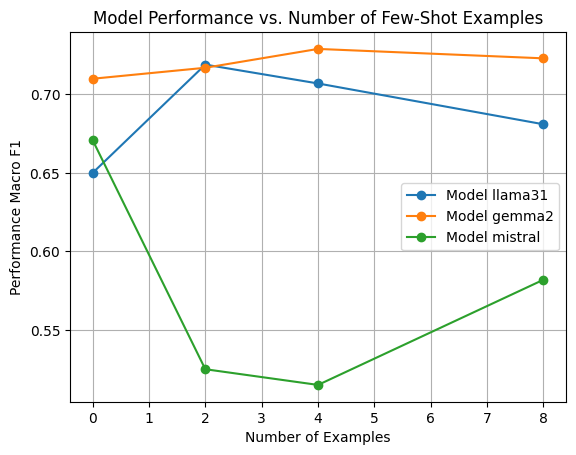

In [ ]:
# Impatto few-shot
num_examples = [0, 2, 4, 8]
models = ["llama31","gemma2","mistral"]
metric = "macro_f1"

for model in models:
  df = pd.read_excel("/content/drive/MyDrive/predictions_hate/Hate_speech_test.xlsx")
  df_model = df[df["model"] == model]
  model_performance = df_model[metric].values
  plt.plot(num_examples, model_performance, marker='o', label=f"Model {model}")

plt.xlabel('Number of Examples')
plt.ylabel('Performance Macro F1')
plt.title('Model Performance vs. Number of Few-Shot Examples')
plt.legend()
plt.grid(True)
plt.show()

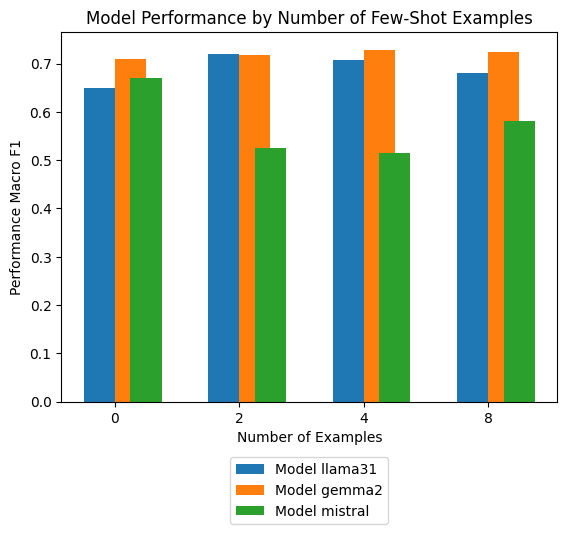

In [ ]:
x = np.arange(len(num_examples))  # La posizione delle barre
width = 0.25  # Larghezza delle barre

# Plot
fig, ax = plt.subplots()
bar_llama = None
bar_gemma2 = None
bar_mistral = None
for model in models:
  df = pd.read_excel("/content/drive/MyDrive/predictions_hate/Hate_speech_test.xlsx")
  df_model = df[df["model"] == model]
  model_performance = df_model[metric].values
  if model == "llama31":
    bar_llama = ax.bar(x - width/2, model_performance, width, label=f'Model {model}')
  elif model == "gemma2":
    bar_gemma2 = ax.bar(x + width/2, model_performance, width, label=f'Model {model}')
  elif model == "mistral":
    bar_mistral = ax.bar(x + width, model_performance, width, label=f'Model {model}')

ax.set_xlabel('Number of Examples')
ax.set_ylabel('Performance Macro F1')
ax.set_title('Model Performance by Number of Few-Shot Examples')
ax.set_xticks(x)
ax.set_xticklabels(num_examples)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35))

plt.show()